<a href="https://colab.research.google.com/github/dondongwon/MLPDataset/blob/main/quickstart_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a quickstart tutorial on colab. In order to quickly explore the dataset on colab, you only need to do the following few steps.

1. Install Transformers (Hugging Face) (This is the **ONLY** package that needs to be installed on Colab)

2. Mount and Upload dataset 

3. Instantiate dataloader class (LP Dataset)

...and you're done! 

In [3]:
# Install huggingface transformer library
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.1 MB/s 
     |████████████████████████████████| 120 kB 45.2 MB/s 
     |████████████████████████████████| 6.6 MB 41.7 MB/s 


In [6]:
#upload dataset such that you can use the dataset on colab

from google.colab import drive
drive.mount('/content/gdrive')

#Make sure the dataset is uploaded to your google Drive, if you upload onto your main directory, 
#you can find it 'Drive/mlpdataset.zip', assuming you've named it mlpdataset.zip
#Then unzip it such that google colab can access it 
!unzip gdrive/My\ Drive/mlpdataset.zip
#Some useful steps here: https://www.aboutdatablog.com/post/how-to-successfully-add-large-data-sets-to-google-drive-and-use-them-in-google-colab


Streaming output truncated to the last 5000 lines.
   creating: data/anat-2/unordered/DM4MWxnXOzM/
  inflating: data/anat-2/unordered/DM4MWxnXOzM/slide_019_trace.csv  
  inflating: data/anat-2/unordered/DM4MWxnXOzM/slide_007.jpg  
  inflating: data/anat-2/unordered/DM4MWxnXOzM/slide_013.jpg  
  inflating: data/anat-2/unordered/DM4MWxnXOzM/slide_018_spoken.csv  
  inflating: data/anat-2/unordered/DM4MWxnXOzM/slide_014_ocr.csv  
  inflating: data/anat-2/unordered/DM4MWxnXOzM/slide_004_ocr.csv  
  inflating: data/anat-2/unordered/DM4MWxnXOzM/slide_012.jpg  
  inflating: data/anat-2/unordered/DM4MWxnXOzM/slide_006.jpg  
  inflating: data/anat-2/unordered/DM4MWxnXOzM/slide_004_spoken.csv  
  inflating: data/anat-2/unordered/DM4MWxnXOzM/slide_015_spoken.csv  
  inflating: data/anat-2/unordered/DM4MWxnXOzM/slide_022_spoken.csv  
  inflating: data/anat-2/unordered/DM4MWxnXOzM/slide_014_trace.csv  
  inflating: data/anat-2/unordered/DM4MWxnXOzM/slide_000_trace.csv  
  inflating: data/anat-2/uno

In [28]:
#Load the dataloader 

import os
import sys
import math
import random
import glob
import pdb
import scipy
import numpy as np
import json as json
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
from transformers import AutoTokenizer, BertModel, AutoModelForQuestionAnswering, BertTokenizerFast, ViltProcessor, ViltModel

from PIL import Image


class LPDataset(data.Dataset):

  def __init__(self, cap_json, fig_json, connect_json, rootdir, wemb_type, transform=None, ids=None):
    """
    Args:
      json: full_dataset.
      transform: transformer for image.
    """

    # if ids provided by get_paths, use split-specific ids
    self.ids = [item for sublist in list(connect_json.values()) for item in sublist] # all ids
    self.transform = transform
    self.cap_json = cap_json
    self.fig_json = fig_json
    self.connect_json = connect_json
    self.root = rootdir

    self.wemb_type = wemb_type

    if 'bert' in self.wemb_type:
      self.bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

    if 'vilt' in self.wemb_type:
      self.vilt_processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")
    
  def __len__(self):
    return len(self.ids)


  def __getitem__(self, index):
    sent, img_id, path, image, ocr, pointers = self.get_raw_item(index)
    ocr_text = " ".join([o['text'] for o in ocr])

    if self.transform is not None:
      image = self.transform(image)
      
    if 'bert' in self.wemb_type:
      spoken_text = self.bert_tokenizer(sent,max_length=512, padding='max_length',truncation=True, return_tensors='pt')
      spoken_target = spoken_text['input_ids'].squeeze()
      ocr_target = self.bert_tokenizer(ocr_text,max_length=40, padding='max_length',truncation=True, add_special_tokens = False, return_tensors='pt')['input_ids']

    if 'vilt' in self.wemb_type:
      fig_ocr = self.vilt_processor(image, ocr_text, max_length=40, padding='max_length',truncation=True, return_tensors="pt")
      
      pointer_target =  torch.zeros_like(spoken_target)
      for point in pointers:
        inds = torch.Tensor([i for i, x in enumerate(spoken_text.word_ids()) if x == point]).long()
        pointer_target[inds] = 1 
      return fig_ocr, spoken_target, pointer_target, index, img_id
    
    return  image, spoken_target, ocr_target, index, img_id

  def get_raw_item(self, index):

    img_id = self.ids[index]

    words = [] 
    captions = self.fig_json[img_id]['captions']
    for word in captions:
      words.append(str(word['Word']))

    sentence = " ".join(words)


    scene_id = self.fig_json[img_id]['scene_id']
    
    if scene_id[0] == os.path.basename(self.root):
      _ = scene_id.pop(0)
    
    
    path = os.path.join(self.root, "/".join(scene_id)+".jpg")
    image = Image.open(path).convert('RGB')

    #crop image here
    cr = self.fig_json[img_id]['slide_figure']
    x = cr["left"]
    y = cr["top"]
    w = cr["width"]
    h = cr["height"]

    # print(cr)
    image = image.crop((x,y,x + w, y + h))
    ocr =  self.fig_json[img_id]['slide_text']
    pointers = self.fig_json[img_id]['pointers']
    
    return sentence, img_id, path, image, ocr, pointers


def get_image_transform():
  normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
  t_list = []

  t_list = [transforms.Resize(256), transforms.CenterCrop(224)]
  t_end = [transforms.ToTensor(), normalizer]
  transform = transforms.Compose(t_list + t_end)
  return transform

def get_image_transform_default():
  t_list = []

  t_list = [transforms.Resize(256)]
  t_end = [transforms.ToTensor()]
  transform = transforms.Compose(t_list + t_end)
  return transform

def default_collate_fn(data, caption_lim = 512):
  # Sort a data list by sentence length
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, spoken_target, ocr_target, index, img_ids = zip(*data)
    # Merge images (convert tuple of 3D tensor to 4D tensor)
    images = torch.stack(images, 0)

    cap_lengths = torch.tensor([len(cap) if len(cap) <= caption_lim else caption_lim for cap in spoken_target])
    spoken_output = torch.zeros(len(spoken_target), caption_lim).long()
    

    for i, cap in enumerate(spoken_target):
      end = cap_lengths[i]
      if end <= caption_lim:
        spoken_output[i, :end] = cap[:end]
      else:
        cap_lengths[i] = caption_lim
        spoken_output[i, :end] = cap[:caption_lim]
    return images, spoken_output, ocr_target, cap_lengths, index, img_ids



In [29]:
sp = 'anat-1'

#define where data is uploaded, by default, the following should work
root_data_dir = 'data'
sp_data_dir = '{}/{}'.format(root_data_dir, sp)

#read jsons 
with open("{}/{}/{}_figs.json".format(root_data_dir, sp,sp), 'r') as f:
 fig_json = json.loads(f.read())

with open("{}/{}/{}.json".format(root_data_dir, sp,sp), 'r') as j:
 cap_json = json.loads(j.read())

with open("{}/{}/{}_capfig.json".format(root_data_dir, sp,sp), 'r') as c:
 connect_json = json.loads(c.read())

#load data
transform = get_image_transform_default() #use get_image_transform() for normalization + cropping + resizing
wemb_type = 'bert'
dataset = LPDataset(cap_json, fig_json, connect_json, sp_data_dir, wemb_type, transform)
loader = torch.utils.data.DataLoader(dataset=dataset,
                                        batch_size=1,
                                        shuffle=True,
                                        pin_memory=True,
                                        num_workers=1,
                                        collate_fn = default_collate_fn
                                        )

In [30]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images

'''
Each sample constitutes of 

images: normalized images of figures (3 x 224 x 224)
spoken_output: word tokens for spoken language (glove or bert)
ocr_target: word tokens for ocr on-slide text (glove or bert)
cap_lengths: length of captions
index: number image ids
img_ids: string image ids
'''

dataiter = iter(loader)
images, spoken_output, ocr_target, cap_lengths, index, img_ids  = dataiter.next()

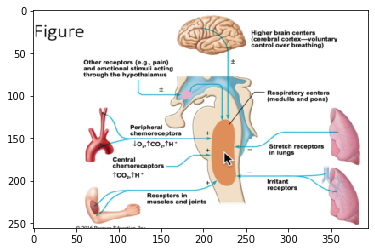

In [33]:
#images (transform not applied)

plt.imshow(images[0].permute(1,2,0).numpy(), interpolation='nearest')
plt.show()

In [35]:
#example of spoken_output 

bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
bert_tokenizer.decode(spoken_output[0], skip_special_tokens = True)

'so this illustration just goes to show you that many different types of stimuli are able to stimulate the respiratory centers in the medulla and the pons so it could be peripheral chemoreceptors it could be central chemoreceptors and receptors and muscles and joints irritants that we spoke about earlier stress stretch receptors in the lungs are again it could be coming from higher brain centers pencil and in your thoughts that you may be experienced for stimulus t - pain all these will end up triggering the respiratory centers and then your breathing gets affected'

In [36]:
#example of OCR

bert_tokenizer.decode(ocr_target[0][0], skip_special_tokens = True)

'figure higher brain centers control over other receptors and emotional stimuli acting through the hypothalamus respiratory centers and peripheral chemoreceptors stretch receptors in lungs central chemoreceptors irritan'